In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

In [2]:
import zipfile
import os
import shutil
import datetime

In [3]:
zip_file_path = 'dataset.zip'
extract_path = './'

In [4]:
# Check if the ZIP file exists
if os.path.exists(zip_file_path):
    # Check if a 'dataset' folder already exists
    dataset_folder = os.path.join(extract_path, 'dataset')
    if os.path.exists(dataset_folder):
        # Rename the existing 'dataset' folder with a timestamp
        timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
        new_dataset_folder_name = f'auto_replaced_dataset_{timestamp}'
        os.rename(dataset_folder, os.path.join(extract_path, new_dataset_folder_name))
        print(f"Existing 'dataset' folder renamed to '{new_dataset_folder_name}'.")

    # Extract the ZIP file to the root directory
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    print("The contents of 'dataset.zip' have been extracted to the 'dataset' folder.")
else:
    print("No 'dataset.zip' file present to extract.")

The contents of 'dataset.zip' have been extracted to the 'dataset' folder.


In [5]:
# Paths to the dataset folders
train_image_folder = "./dataset/images/"
train_mask_folder = "./dataset/masks/"
validate_image_folder = "./dataset/validate/images/class1/"
validate_mask_folder = "./dataset/validate/masks/"
print(train_image_folder)

./dataset/images/


In [6]:
# Load the file names
train_images = glob.glob(train_image_folder + "*.jpg")
train_masks = glob.glob(train_mask_folder + "*.png")
validate_images = glob.glob(validate_image_folder + "*.jpg")
validate_masks = glob.glob(validate_mask_folder + "*.png")

print(train_images)

['./dataset/images\\104_sat.jpg', './dataset/images\\113_sat.jpg', './dataset/images\\343_sat.jpg', './dataset/images\\388_sat.jpg', './dataset/images\\541_sat.jpg', './dataset/images\\562_sat.jpg', './dataset/images\\602_sat.jpg', './dataset/images\\627_sat.jpg', './dataset/images\\655_sat.jpg', './dataset/images\\951_sat.jpg']


In [7]:
train_images = sorted(glob.glob(train_image_folder + "*.jpg"))
train_masks = sorted(glob.glob(train_mask_folder + "*.png"))
validate_images = sorted(glob.glob(validate_image_folder + "*.jpg"))
validate_masks = sorted(glob.glob(validate_mask_folder + "*.png"))

In [8]:
# Image Preprocessing
def preprocess_image(input_data):
    """
    This function takes the path of an image or an image and returns the preprocessed image.
    Preprocessing steps include converting to HSV color space and applying Gaussian blurring.
    """
    print(input_data)
    # Read the image
    if isinstance(input_data, str):
        # If input is a file path, read the image
        image = cv2.imread(input_data)
    else:
        # If input is an array, use it directly
        image = input_data

    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply Gaussian blurring to reduce noise and improve edge detection
    # NOTE: Commented because we may not need this. Add it if the results get worse.
    # blurred_image = cv2.GaussianBlur(hsv_image, (5, 5), 0)

    # return blurred_image
    return hsv_image

In [9]:
# Color-based Segmentation
def color_segmentation(image):
    """
    This function takes an HSV image and returns a mask that segments out roads and tracks based on color.
    """
    # Define lower and upper bounds for the HSV values of roads and tracks
    lower_bound = np.array([0, 00, 00])
    upper_bound = np.array([255, 150, 150])

    # Create a mask using inRange function
    mask = cv2.inRange(image, lower_bound, upper_bound)

    return mask

In [10]:
# Feature Extraction
def edge_detection(image):
    """
    This function takes an HSV image and returns an edge-detected image using the Canny algorithm.
    """
    # Use the Value channel of HSV for edge detection
    value_channel = image[:,:,2]

    # Apply Canny edge detection
    edges = cv2.Canny(value_channel, 60, 180)

    return edges

In [11]:
# Morphological Operations
def apply_morphology(image):
    """
    This function takes an image with edges detected and applies morphological operations.
    """
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply dilation followed by erosion (Closing)
    dilated = cv2.dilate(image, kernel, iterations = 3)
    eroded = cv2.erode(dilated, kernel, iterations = 1)

    return eroded

In [12]:

def find_contours(image):
    """
    This function takes an image with edges and morphological operations applied,
    then finds and returns contours.
    """
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours based on area (Optional)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

    return contours

In [13]:
# Post-Processing
def create_mask(contours, shape):
    """
    This function takes detected contours and creates a mask.
    """
    mask = np.zeros(shape, np.uint8)
    cv2.drawContours(mask, contours, -1, (255, 255, 255), thickness=cv2.FILLED)

    return mask

In [14]:
def post_process(image):
    kernel_size = 3
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return opening

In [15]:
# IoU Calculation
def calculate_iou(predicted_mask, ground_truth_mask):
    """
    This function takes a predicted mask and a ground truth mask and returns the Intersection over Union (IoU) score.
    """
    # Calculate intersection and union
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)

    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [16]:
def visualize_results(original_image, edges, morphed, contours_image, mask, ground_truth_mask, iou_score):
    """
    This function takes the original image, the edge-detected image, the morphologically operated image,
    the image with contours, the generated mask, the ground truth mask, and the IoU score,
    then visualizes them.
    """
    plt.figure(figsize=(20,20))

    plt.subplot(1,6,1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1,6,2)
    plt.title("Edge Detection")
    plt.imshow(edges, cmap="gray")
    plt.axis("off")

    plt.subplot(1,6,3)
    plt.title("Morphological Operations")
    plt.imshow(morphed, cmap="gray")
    plt.axis("off")

    plt.subplot(1,6,4)
    plt.title("Contours")
    plt.imshow(contours_image, cmap="gray")
    plt.axis("off")

    plt.subplot(1,6,5)
    plt.title(f"Segmented Mask - IoU: {iou_score:.2f}")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,6,6)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_mask, cmap="gray")
    plt.axis("off")

    plt.show()

In [17]:
def visualize_results_compared(original_image, color_mask, edges, combined, morphed, contours_image, mask, ground_truth_mask, iou_score):
    plt.figure(figsize=(12, 24))

    images = [original_image, color_mask, edges, combined, morphed, contours_image, mask, ground_truth_mask]
    titles = ["Original Image", "Color Segmentation", "Edge Detection", "Color & Edges Combined",
              "Morphological Operations", "Contours", f"Segmented Mask - IoU: {iou_score:.2f}", "Ground Truth Mask"]

    for i in range(4):
        plt.subplot(4, 2, 2*i+1)
        plt.title(titles[2*i])
        plt.imshow(images[2*i])
        plt.axis("off")

        plt.subplot(4, 2, 2*i+2)
        plt.title(titles[2*i+1])
        plt.imshow(images[2*i+1], cmap='gray')
        plt.axis("off")

    plt.show()

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(predicted_mask, ground_truth_mask):
    # Flatten the masks to compare element-wise
    predicted_flat = predicted_mask.flatten()
    ground_truth_flat = ground_truth_mask.flatten()

    # Binary thresholding may be necessary if the masks are not binary
    predicted_flat = (predicted_flat > 127).astype(np.uint8)
    ground_truth_flat = (ground_truth_flat > 127).astype(np.uint8)

    precision = precision_score(ground_truth_flat, predicted_flat)
    recall = recall_score(ground_truth_flat, predicted_flat)
    f1 = f1_score(ground_truth_flat, predicted_flat)

    return precision, recall, f1

In [19]:

def calculate_accuracy(predicted_mask, ground_truth_mask):
    correct = np.sum(predicted_mask == ground_truth_mask)
    total = ground_truth_mask.size
    accuracy = correct / total
    return accuracy

./dataset/validate/images/class1\1054_sat.jpg


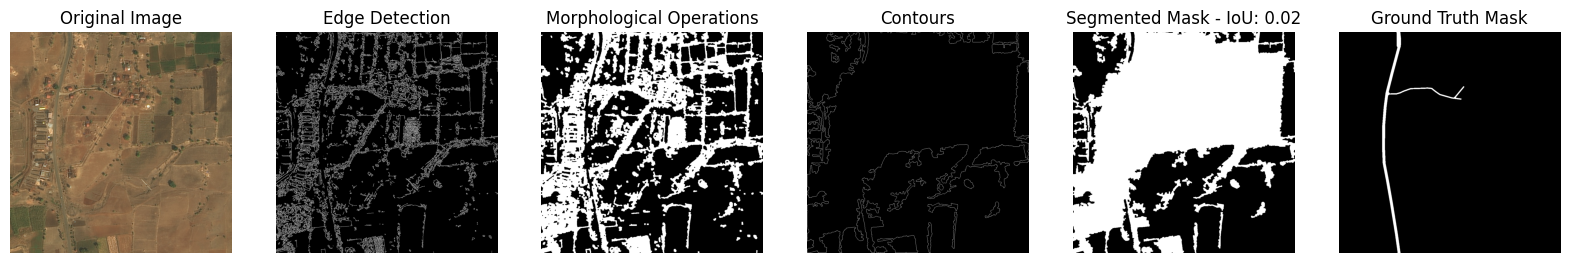

IoU: 0.019375848032564452, Precision: 0.01953575834759422, Recall: 0.7030075187969925, F1 Score: 0.03801512086039825
Accuracy: 0.4313774108886719
./dataset/validate/images/class1\1849_sat.jpg


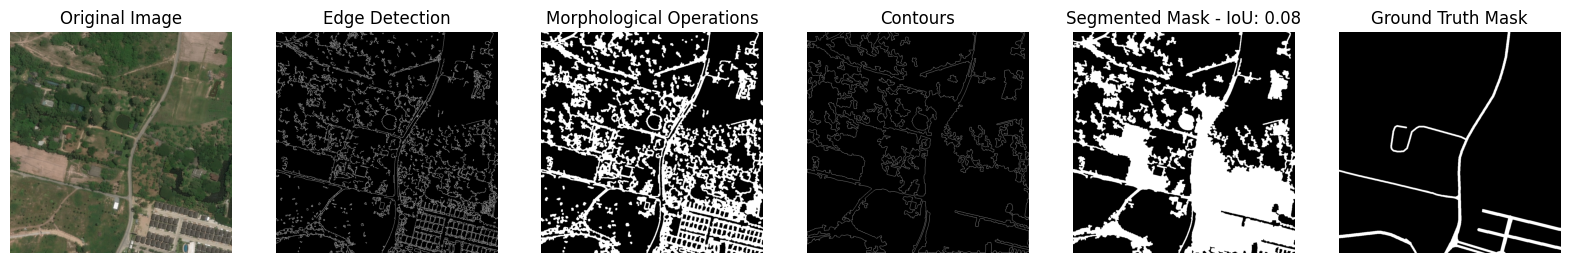

IoU: 0.07954379094535739, Precision: 0.08198476018031271, Recall: 0.7276417660598452, F1 Score: 0.14736556610769969
Accuracy: 0.6162471771240234
./dataset/validate/images/class1\1934_sat.jpg


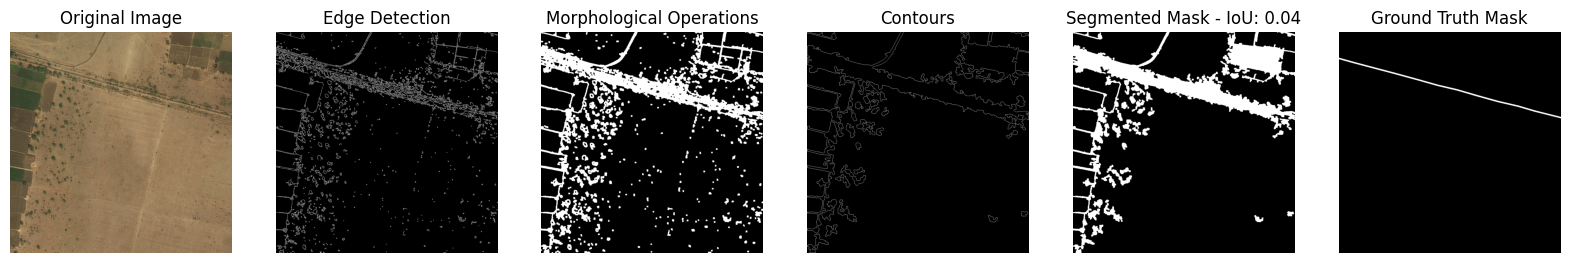

IoU: 0.04048940749971678, Precision: 0.04053188171585722, Recall: 0.9747715805263876, F1 Score: 0.07782762074822525
Accuracy: 0.8384552001953125
./dataset/validate/images/class1\1945_sat.jpg


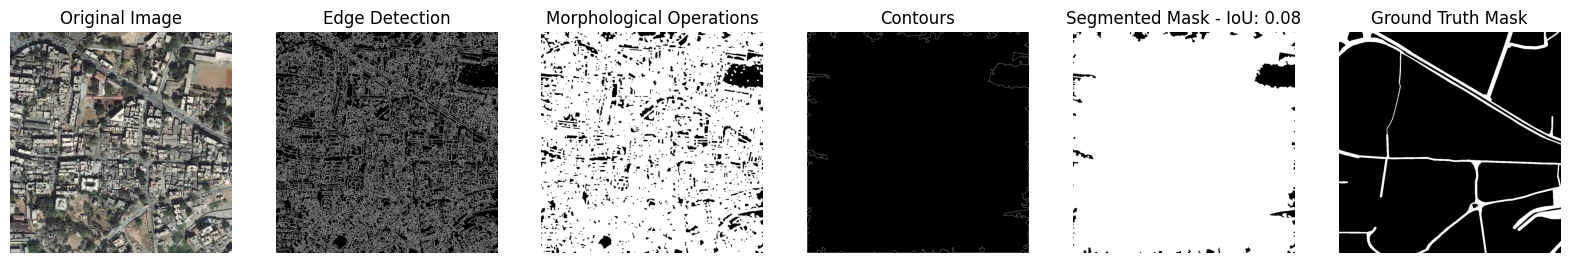

IoU: 0.0775925767410193, Precision: 0.07808210090881099, Recall: 0.9252419780606558, F1 Score: 0.14401097115142308
Accuracy: 0.10592079162597656
./dataset/validate/images/class1\2129_sat.jpg


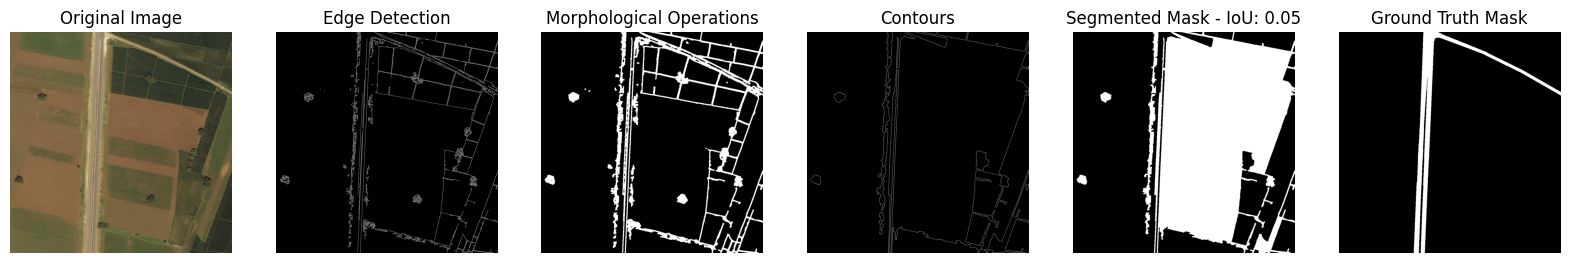

IoU: 0.050810925545360694, Precision: 0.053922662794959955, Recall: 0.4682243323020022, F1 Score: 0.09670802674418391
Accuracy: 0.5308847427368164
./dataset/validate/images/class1\2262_sat.jpg


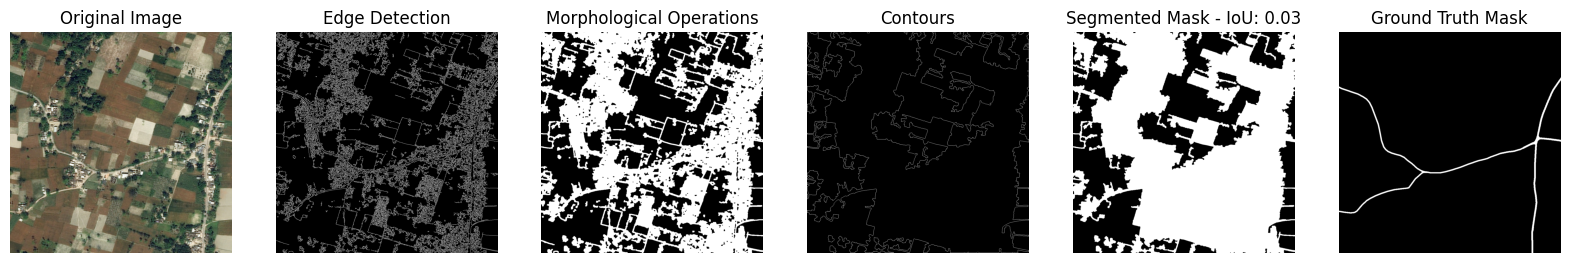

IoU: 0.027354126984363743, Precision: 0.027359717854308272, Recall: 0.9925849751028362, F1 Score: 0.05325160286192158
Accuracy: 0.37811851501464844


In [20]:
# Main Function
def main():
    """
    Main function to execute the complete pipeline for road segmentation.
    """
    # Loop through the validation set
    for image_path, mask_path in zip(validate_images, validate_masks):

        # Preprocess the image
        preprocessed = preprocess_image(image_path)

        # Apply edge detection
        edges = edge_detection(preprocessed)

        # Apply morphological operations
        morphed = apply_morphology(edges)
        # Apply post-processing (opening)
        post_processed = post_process(morphed)

        # Find contours
        contours = find_contours(post_processed)

        # Draw contours on a black image for visualization
        contours_image = np.zeros_like(morphed)
        cv2.drawContours(contours_image, contours, -1, (255), 1)

        # Create mask
        mask = create_mask(contours, preprocessed.shape[:2])

        # Read ground truth mask
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Calculate IoU
        iou_score = calculate_iou(mask, ground_truth_mask)

        # Calculate additional metrics
        precision, recall, f1 = calculate_metrics(mask, ground_truth_mask)

        # Visualize results
        original_image = cv2.imread(image_path)
        visualize_results(original_image, edges, morphed, contours_image, mask, ground_truth_mask, iou_score)
        print(f"IoU: {iou_score}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        accuracy = calculate_accuracy(mask, ground_truth_mask)
        print(f"Accuracy: {accuracy}")
# Execute the main function
main()

In [21]:
import tensorflow as tf

from tensorflow.keras import layers, models

In [22]:
def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Downsampling path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck layer
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)

    # Upsampling path
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u1)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u2)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [23]:
def load_images_and_masks(image_paths, mask_paths, target_size=(256, 256)):
    images = [cv2.resize(cv2.imread(path), target_size) / 255.0 for path in image_paths]
    masks = [cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), target_size) / 255.0 for path in mask_paths]
    masks = [np.expand_dims(mask, axis=-1) for mask in masks]  # Add channel dimension to masks

    return np.array(images), np.array(masks)

In [24]:

train_image_paths = glob.glob(os.path.join(train_image_folder, "*.jpg"))
train_mask_paths = glob.glob(os.path.join(train_mask_folder, "*.png"))


In [25]:
train_images, train_masks = load_images_and_masks(train_image_paths, train_mask_paths)


In [26]:

# Assuming you have the unet_model function defined
model = unet_model()

# Train the model
model.fit(train_images, train_masks, batch_size=32, epochs=50, validation_split=0.1)

# Save the trained model weights
model.save('unet-model-road-extraction.h5')

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - accuracy: 0.5839 - loss: 0.9072 - val_accuracy: 0.8860 - val_loss: 0.5651
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.3989 - loss: 1.0447 - val_accuracy: 0.5861 - val_loss: 0.6330
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.4574 - loss: 0.7956 - val_accuracy: 0.3351 - val_loss: 0.7529
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5496 - loss: 0.7466 - val_accuracy: 0.2311 - val_loss: 0.9225
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5968 - loss: 0.7368 - val_accuracy: 0.2163 - val_loss: 1.0143
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5986 - loss: 0.7170 - val_accuracy: 0.2668 - val_loss: 0.9659
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - accuracy: 0.5947 - loss: 0.6992 - val_accuracy: 0.2796 - val_loss: 0.8569
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.5715 - loss: 0.6871 - val_accuracy: 0.4115 - val_loss: 0.7551


In [27]:
import matplotlib.pyplot as plt

def modified_visualize_results(original_image, predicted_mask, resized_mask, ground_truth_mask, iou_score):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Resized Predicted Mask")
    plt.imshow(resized_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title(f"Ground Truth Mask - IoU: {iou_score:.2f}")
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.axis('off')

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.01677426182664832, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9645595550537109


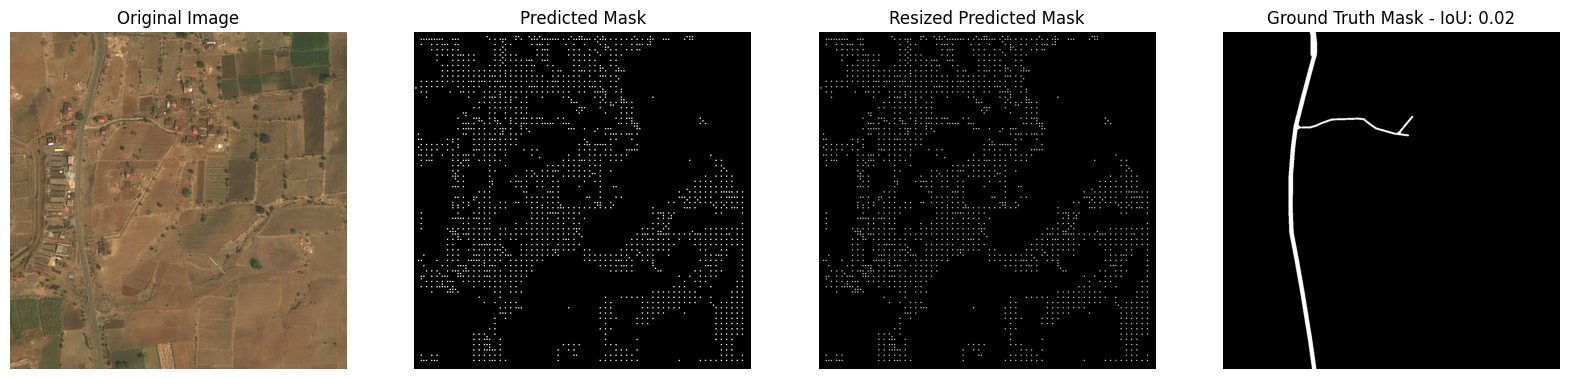

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.035423725742448675, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9492321014404297


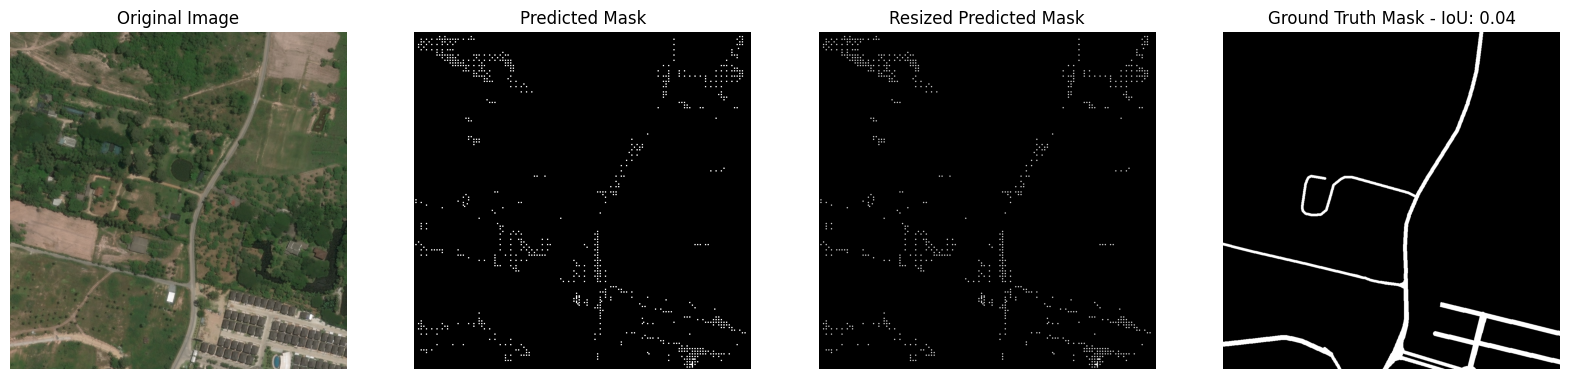

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.014156423897755763, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9692506790161133


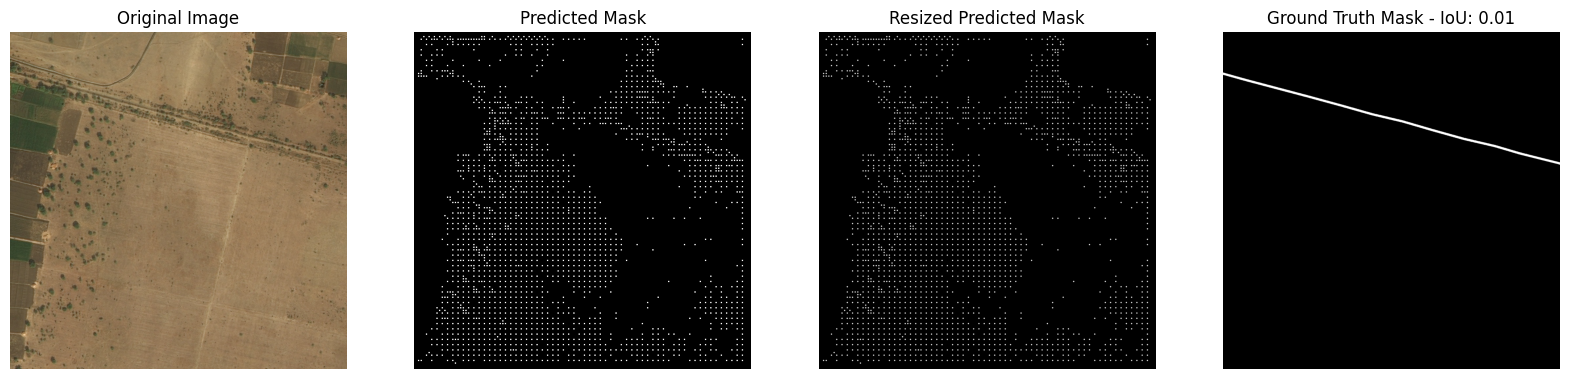

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.031908157365856345, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.8658599853515625


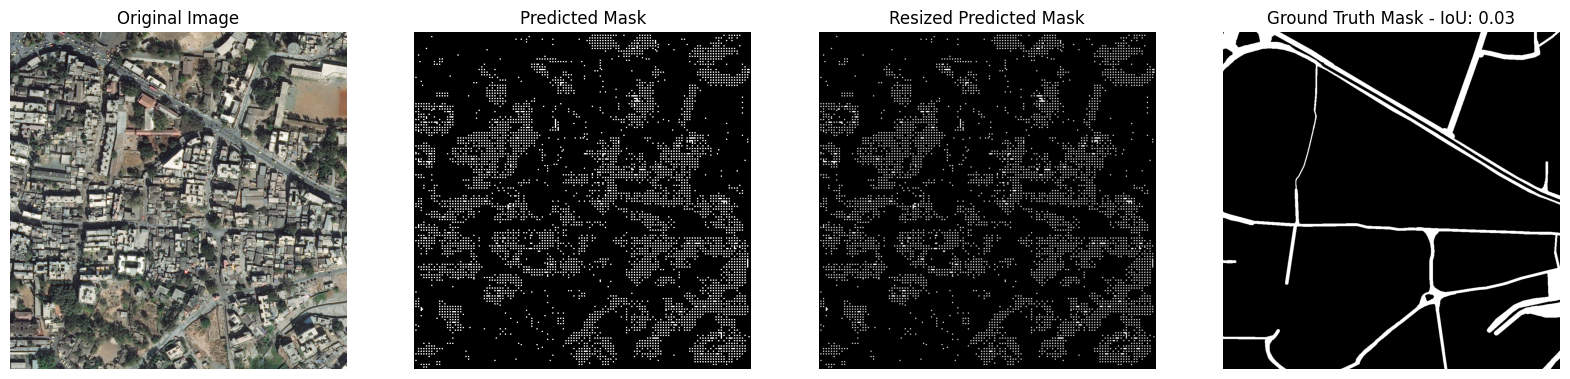

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.014062794402288416, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9451065063476562


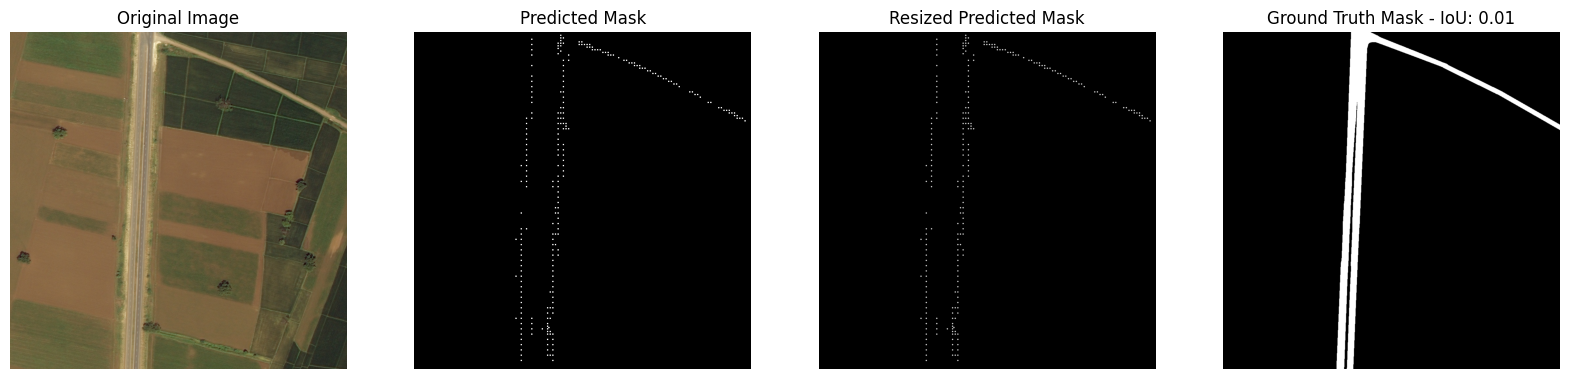

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\subash\Documents\Charles Darwin University\Semester-1-2024\Thesis Part-B\Road Detection\jupyter-env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined a

IoU: 0.03176579068695251, Precision: 0.0, Recall: 0.0, F1 Score: 0.0, Accuracy: 0.9599437713623047


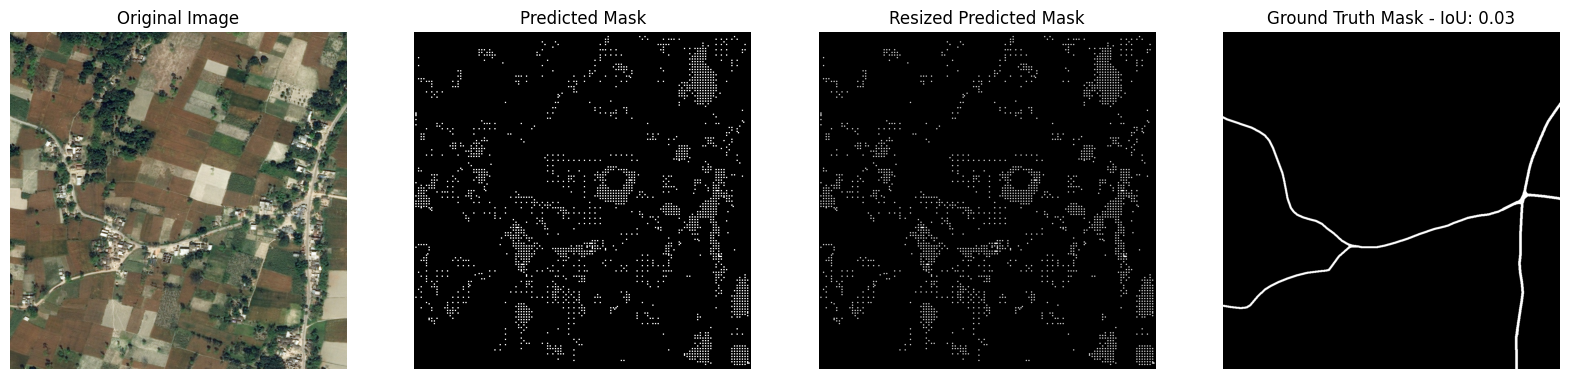

In [28]:
def main():
    model = unet_model()
    model.load_weights('unet-model-road-extraction.h5')

    for image_path, mask_path in zip(validate_images, validate_masks):
        original_image = cv2.imread(image_path)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Resize and preprocess for U-Net
        unet_input = cv2.resize(original_image, (256, 256))
        unet_input = np.expand_dims(unet_input, axis=0) / 255.0

        # Predict mask using U-Net
        predicted_mask = model.predict(unet_input).squeeze()
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

        # Resize the predicted mask to match the ground truth mask's dimensions
        predicted_mask_resized = cv2.resize(predicted_mask, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]))

        # Normalize and threshold ground truth mask
        ground_truth_mask_binary = (ground_truth_mask > 127).astype(np.uint8)

        # Calculate metrics
        iou_score = calculate_iou(predicted_mask_resized, ground_truth_mask_binary)
        precision, recall, f1 = calculate_metrics(predicted_mask_resized, ground_truth_mask_binary)
        accuracy = calculate_accuracy(predicted_mask_resized, ground_truth_mask_binary)

        print(f"IoU: {iou_score}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")

        # Visualize results
        # Note: You may need to adjust what images you pass based on what you want to visualize
        modified_visualize_results(original_image, predicted_mask, predicted_mask_resized, ground_truth_mask_binary, iou_score)

if __name__ == "__main__":
    main()

In [29]:
def modified_find_contours(image):
    """
    This function takes an image with edges and morphological operations applied,
    then finds and returns contours along with the image with contours drawn.
    """
    # Using cv2.findContours() and handling its return values properly depending on OpenCV version
    if cv2.__version__.startswith('4.'):
        contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, hierarchy = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Drawing contours for visualization
    contours_image = np.zeros_like(image)
    cv2.drawContours(contours_image, contours, -1, (255, 255, 255), 1)

    # Filter out small contours based on area if necessary
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 500]

    return contours_image, filtered_contours

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

def create_datagen(augment=False):
    return ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255
    ) if augment else ImageDataGenerator(rescale=1./255)

def setup_generators(base_dir, batch_size=32, augment=False):
    """ Configure and return generators for both images and masks. """
    # Common seed ensures images and masks stay aligned
    seed = 42

    image_datagen = create_datagen(augment)
    mask_datagen = create_datagen(augment)
    
    image_generator = image_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'images/'),
        class_mode=None,
        color_mode='rgb',
        target_size=(256, 256),
        batch_size=batch_size,
        seed=seed,
        shuffle=True  # Ensure the shuffling is on for the training set
    )

    mask_generator = mask_datagen.flow_from_directory(
        directory=os.path.join(base_dir, 'masks/'),
        class_mode=None,
        color_mode='grayscale',
        target_size=(256, 256),
        batch_size=batch_size,
        seed=seed,
        shuffle=True  # Ensure the shuffling is on for the training set
        
    )
    
    return (pair for pair in zip(image_generator, mask_generator))


# Paths for generator
train_dir = './dataset'
val_dir = './dataset'

train_gen = setup_generators(train_dir, batch_size=32, augment=True)
val_gen = setup_generators(val_dir, batch_size=32)

def train_model(train_generator, val_generator, steps_per_epoch, validation_steps, epochs=10):
    model = unet_model()
    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
    return model

Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 10 images belonging to 1 classes.


In [ ]:
# Number of steps per epoch should be (number of images / batch_size)
# If you have a different number of images and masks, adjust accordingly.
steps_per_epoch = len(os.listdir('./dataset/validate/images/')) // 32
validation_steps = len(os.listdir('./dataset/validate/masks/')) // 32
# steps_per_epoch = 10
# validation_steps = 0.3

# Now we can train the model
model = train_model(train_gen, val_gen, steps_per_epoch, validation_steps)
model.save('hybrid-unet-road-extraction.h5')

Epoch 1/10
    240/Unknown 4259s 18s/step - accuracy: 0.8643 - loss: 0.4618

In [ ]:
def main():
    model = unet_model()
    model.load_weights('hybrid-unet-road-extraction.h5')

    for image_path, mask_path in zip(validate_images, validate_masks):
        original_image = cv2.imread(image_path)
        ground_truth_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Preprocess the image
        preprocessed_image = preprocess_image(original_image)

        # Resize for U-Net input and predict
        unet_input = cv2.resize(preprocessed_image, (256, 256))
        unet_input = np.expand_dims(unet_input, axis=0) / 255.0
        predicted_mask = model.predict(unet_input).squeeze()
        predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
        predicted_mask_resized = cv2.resize(predicted_mask, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]))

        # Step 2: Traditional Techniques (Edge Detection and Contours)
        edges = edge_detection(preprocessed_image)
        contours_image, contours = modified_find_contours(edges)
        traditional_mask = create_mask(contours, preprocessed_image.shape[:2])

        # Ensure traditional mask is resized for comparison
        if traditional_mask.shape != predicted_mask_resized.shape:
            traditional_mask = cv2.resize(traditional_mask, (predicted_mask_resized.shape[1], predicted_mask_resized.shape[0]))

        # Combine traditional and U-Net results
        combined_mask = np.maximum(predicted_mask_resized, traditional_mask)

        # Normalize and threshold ground truth mask
        ground_truth_mask_binary = (ground_truth_mask > 127).astype(np.uint8)

        # Calculate metrics
        iou_score = calculate_iou(combined_mask, ground_truth_mask_binary)
        precision, recall, f1 = calculate_metrics(combined_mask, ground_truth_mask_binary)
        accuracy = calculate_accuracy(combined_mask, ground_truth_mask_binary)

        print(f"IoU: {iou_score}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}, Accuracy: {accuracy}")

        # Visualize results
        modified_visualize_results(original_image, predicted_mask_resized, combined_mask, ground_truth_mask_binary, iou_score)

if __name__ == "__main__":
    main()